# Playing around with the Titanic dataset

source: https://www.kaggle.com/competitions/titanic/data

## 1. Data exploration

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv('data/train.csv')
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Getting the columnames for easier filtering and overview

In [11]:
print(set(df.columns))

{'PassengerId', 'Age', 'Fare', 'Sex', 'Survived', 'Name', 'Ticket', 'Pclass', 'SibSp', 'Embarked', 'Parch', 'Cabin'}


**Explnation for each colum name**
- PassengerId: a unique identifier for each passenger (integer)
- Age: The age for each passenger (float)
- Fare: Passenger fare (float)
- Sex: gender of the passneger (category)
- Survived: did the passenger survie or not (bool)
- Name: Full name of the passneger
- Ticket: ticket number (string)
- Pclass: A proxy for socio-economic status (SES) 
    - 1st: Upper
    - 2nd: Middle
    - 3rd: Lower
- SibSp: The dataset defines family relations in this way
    - Sibling: brother, sister, stepbrother, stepsister
    - Spouse: husband, wife (mistresses and fiancés were ignored)
- Embarked: Port of Embarkation
    - C: Cherbourg
    - Q: Queenstown
    - S: Southampton
- Parch: The dataset defines family relations in this way
    - Parent: mother, father
    - Child: daughter, son, stepdaughter, stepson
    - Some children travelled only with a nanny, therefore parch=0 for them
- Cabin: The cabin number

---

### Filtering out the interesing columns

In [12]:
df_filter = df[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Survived']]
df_filter.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0


### Looking over the dataset to make sure there is no NaN vallues 

In [13]:
df_filter.isna().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
Survived      0
dtype: int64

All of the filtered columns have 0 NaN-values except the Age which have 177 NaN-values, and the Embarked with 2 NaN-values.

*This is one of the most common way to handle this type of NaN-value problems*

### Handeling the NaN-values

**NOTE**: The Age column missing values is replaced with the ```mean()``` of the ages and the ```mode()``` replace the NaN-value with the most common value

In [14]:
df_filter.fillna(df_filter.Age.mean(), inplace=True)
df_filter.fillna(df_filter.Embarked.mode()[0], inplace=True)

/var/folders/wq/7cvbc6jd411dg1wd3j_ksjv80000gn/T/ipykernel_1133/1071940086.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter.fillna(df_filter.Age.mean(), inplace=True)
/var/folders/wq/7cvbc6jd411dg1wd3j_ksjv80000gn/T/ipykernel_1133/1071940086.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter.fillna(df_filter.Embarked.mode()[0], inplace=True)


Checking the dataset after the missing-value handeling

In [16]:
df_filter.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64

### Plotting the data

#### Age

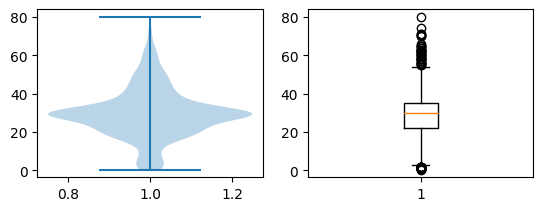

In [30]:
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.violinplot(df_filter.Age)

plt.subplot(2, 2, 2)
plt.boxplot(df_filter.Age)

plt.show()

The violine plot represent the age distribution. As shown in the plot, we can see that the majority of the passengers on the Titanic was at the age of 30. By observing the plot further, we can set the reange between 25-35 is the majority of the passengers. The oldest passenger have an age of 79+ yeas and the younges have an age > 10. The boxplot represent the same as the violinplot. 

#### Fare

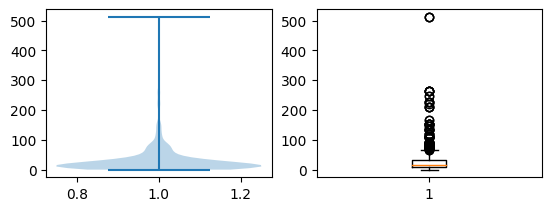

In [32]:
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.violinplot(df_filter.Fare)

plt.subplot(2, 2, 2)
plt.boxplot(df_filter.Fare)

plt.show()

## 2. Model training

In [34]:
from scipy.stats import zscore 
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

Select the columns we want to use for training...

In [35]:
print(set(df.columns))

{'PassengerId', 'Age', 'Fare', 'Sex', 'Survived', 'Name', 'Ticket', 'Pclass', 'SibSp', 'Embarked', 'Parch', 'Cabin'}


In [36]:
train_cols = ['Age', 'Fare', 'SibSp', 'Parch']

Selecting the outliers and removing them based on the ```train_cols``` for smother training...

In [37]:
z_score = np.abs(zscore(df_filter[train_cols]))
threehhold_z_score = 3
outliers = np.any(z_score > threehhold_z_score, axis=1)
df_new = df_filter[~outliers]
df_new.head(3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1


In [40]:
print(f'Old datafram shape: {df_filter.shape}')
print(f'New datafram shape: {df_new.shape}')

Old datafram shape: (891, 8)
New datafram shape: (820, 8)


### Preprcessing and labeling

In [41]:
from sklearn.preprocessing import StandardScaler, LabelEncoder